# TP3: Mean Shift

## Instructions
Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf. 

Before sending your notebook, please make sure your code can be run by restarting your jupyter kernel and relaunching all the cells.

Return your work by e-mail at `gabriel.fiastre@inria.fr` using a single file (ipynb or zip) with the format `LASTNAME_FirstName_TP2.ipynb`

**During this TP, you will implement the Mean Shift algorithm for clustering, and use it for image sementation (pixel clustering)**

## Imports

In [1]:
# See TP1 for information about those imports
import numpy as np
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray'

import time
from numba import njit

# For colorspace conversions in the last section
from skimage.color import rgb2lab,lab2rgb

## 1. Mean shift

In this section, we will implement Mean Shift and test it on simple synthetic data (*i.e.*, points you will sample from a probability distribution with known density - see below).

**1.a)** Generate a random vector of 100 2D points `data1` with: 
- 50 points sampled from a Gaussian distribution of variance (1, 1) centered in (0, 0),
- 50 points sampled from a Gaussian distribution of variance (1, 1) centered in (2, 1).<br/>

Plot your points using the `plt.scatter` function.

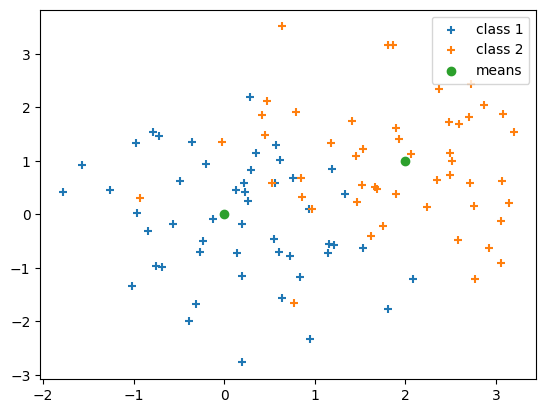

In [2]:
# Hint : consider using np.random.multivariate_normal

rdvec1 = np.random.multivariate_normal([0,0],[[1,0],[0,1]],50)
rdvec2 = np.random.multivariate_normal([2,1],[[1,0],[0,1]],50)
data1 = np.concatenate((rdvec1,rdvec2))

plt.scatter(data1[:50,0],data1[:50,1], label="class 1", marker="+")
plt.scatter(data1[50:,0],data1[50:,1], label="class 2", marker="+")
plt.scatter([0,2],[0,1], label="means")
plt.legend()
plt.show()

**1.b)** Do the same to create a vector `data2` with the center of the second Gaussian in (3,3). 

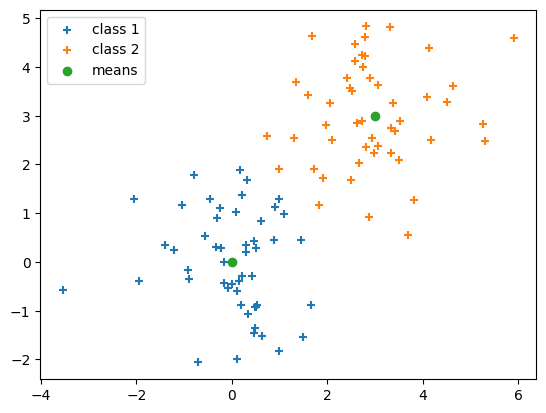

In [3]:
# Hint : consider using np.random.multivariate_normal

rdvec1 = np.random.multivariate_normal([0,0],[[1,0],[0,1]],50)
rdvec2 = np.random.multivariate_normal([3,3],[[1,0],[0,1]],50)
data2 = np.concatenate((rdvec1,rdvec2))

plt.scatter(data2[:50,0],data2[:50,1], label="class 1", marker="+")
plt.scatter(data2[50:,0],data2[50:,1], label="class 2", marker="+")
plt.scatter([0,3],[0,3], label="means")
plt.legend()
plt.show()

#### Note :
In the following, you will try to form clusters from the points in `data1` and `data2`. The algorithm you will develop should be able to separate the points coming from each of the two Gaussian distributions.

In each of the following experiment, **test on both `data1` and `data2`**.

**1.c)** After having visual comparison, which do you think will be the easiest `data` vector to cluster and why?

`data2` sera le plus facile à regrouper parce que les deux groupes sont plus loins donc les proba d'intersection sont très faibles alors que dans `data1` il y a beaucoup d'intersection.

In the end of this homework, we will segment images using a different **bandwidth** for space and color. For this reason, we will use **a *d*-dimensional vector `sigma`** as a parameter for all our mean-shift functions. It defines a scale for each dimension (*i.e.*, we want to do an anisotropic clustering). 

**2.** What is the role of the bandwith parameter(s) ? What would be a meaningful parameter `sigma` for each of the synthetic data sets (`data1` and `data2`)? Explain why.

In [4]:
"""
sigma is the standard deviation of the gaussian kernel.
It is the parameter that controls the smoothness of the density estimation.
A small sigma will result in a density estimation that is very sensitive to the data,
and a large sigma will result in a density estimation that is very smooth.

In the case of data1, a small sigma is appropriate because the data is very dense and the density estimation should be sensitive to the data.
In the case of data2, a large sigma is appropriate because the data is very sparse and the density estimation should be smooth.
"""

sigma1 = 0.5
sigma2 = 1

The formula in the lectures are mostly derived for the isotropic case. The simple way to deal with the anisotropy is to divide each coordinate $x_i$ by its corresponding $\sigma_i$ rather than by a global $\sigma$ -- *e.g.* distance between points $\mathbf x$ and $\mathbf y$ normalized by $\sigma$ becomes $\sqrt{\sum_i^d{\left(\frac{\mathbf x_i- \mathbf y_i}{\sigma_i}\right)^2}}$.

**Bonus math question.** *(Answer it **only** when you have finished the TP)* What changes exactly in the anisotropic case? Why is doing that valid? What consequences does it have on gradients?

___

In the anisotropic case, the covariance matrix is not diagonal anymore.
The formula for the density estimation is the same, but the distance between points is not the same.
The distance between points is now the Mahalanobis distance, which is the Euclidean distance between points normalized by the covariance matrix.

Doing that is valid because the Mahalanobis distance is a valid distance, and it adapts the normalization to the local characteristics of the data.
By considering different scaling factors for each coordinate, it provides a more accurate representation of the geometry of the data.

The gradient with respect to each coordinate will be scaled by the inverse of its corresponding scaling factor.
This ensures that the optimization process takes into account the different sensitivities along each axis.

----

### Let's recall the Mean shift algorithm. 

Suppose you have data $X$, and an arbitrary kernel function $k$ (a comon example is the gaussian kernel) 

The target pdf to estimate would be defined as: 
$$f(X_j)=\frac{c}{N}\sum_i^N{k\left(||\frac{\mathbf X_j - \mathbf X_i}{\sigma_i}||^2\right)}$$
Note that $\sigma$ is the bandwith parameter, and $c$ a normalizing constant.

We now want to cluster the data points by finding for each the closest local minimum with respect to this pdf.

The Mean shift algorithm iterates as follows :

#### Mean Shift Algorithm

1. **Initialization:**
   - For each data point $X_j$, initialize the mean shift vector $M(X)$ to be zero.
   - Choose a bandwidth parameter $\sigma$ for your kernel function $k$ and $\epsilon$.

2. **Mean Shift Computation:**
   - For each point $X_j$, set $x\longleftarrow X_j$ and repeat until convergence:
     
     - Set  $x \leftarrow x + M(x)$
       
       with $M(x)$ the weighted average of the vectors pointing from $x$ to all other points in the dataset:
       
       This is :
       
       $$ M(x) = \frac{\sum_i^N X_i g\left(\frac{\|x - X_i\|^2}{\sigma^2}\right) }{\sum_i^N g\left(\frac{\|x - X_i\|^2}{\sigma^2}\right)} $$
       with $g(x)=-k'(x)$ the direction

      If $M(x)<\epsilon$, stop

   - Assign $X_j$ to the found minimum $x^*$, called **mode** 


3. **Return Modes and labels for all points (with eventually some post-processing such as merging close nodes etc.)**

**3.a)** Implement the function `MS_step` which takes as input a vector of all the data points `data`, a starting point `x`, the standard deviations `sigma` and an arbitrary kernel fucntion and returns the updated position of the point `x` after one step of the mean-shift algorithm. <br/>


**3.b)** Test it on your synthetic data (on `data1`, then on `data2`) and visualize the result.

In [5]:
def sqr_mahalanobis_distance(x1, x2, cov): # since we don't care about norm but only distance, we don't need the mean
    # if cov is a scalar, we assume it is the variance
    if np.isscalar(cov):
        cov = np.eye(x1.shape[-1]) * cov
    # if cov is a vector, we assume it is the diagonal of the covariance matrix
    elif cov.ndim == 1:
        cov = np.diag(cov)
    # if cov is a matrix, we assume it is the covariance matrix
    elif cov.ndim == 2:
        pass
    else:
        raise ValueError("cov must be a scalar, a vector or a matrix")
    
    diff = x1-x2
    return np.sum(diff @ np.linalg.inv(cov) * diff, axis=-1)

def k(x):
    """
    k is the gaussian kernel.
    """
    return np.exp(-x/2)

def g(x):
    """
    g = - k'(x)
    """
    return 1/2 * np.exp(-x/2)

def MS_step(data, xs, cov, g_function=g):
    repeated_data = np.repeat(data[:,None,:], len(xs), axis=1)
    
    dist = sqr_mahalanobis_distance(repeated_data, xs, cov)
    gs = g_function(dist)
    M = np.sum(repeated_data * gs[:,:,None], axis=0) / np.sum(gs, axis=0)[:,None] - xs
    
    return M

"""
This is slower than the non compiled version.
"""
@njit
def MS_step_compiled(data, xs, sigma, g_function=g):
    repeated_data = np.zeros((len(data), len(xs), 2))
    for i in range(len(data)):
        repeated_data[:, i] = data

    diff = repeated_data-xs
    norm = np.zeros((len(data), len(xs)))
    for i in range(len(data)):
        for j in range(len(xs)):
            norm[i,j] = np.linalg.norm(diff[i,j])

    gs = g_function((norm/sigma)**2)
    M = np.sum(repeated_data * gs[:,:,None], axis=0) / np.sum(gs, axis=0)[:,None] - xs
    
    return M

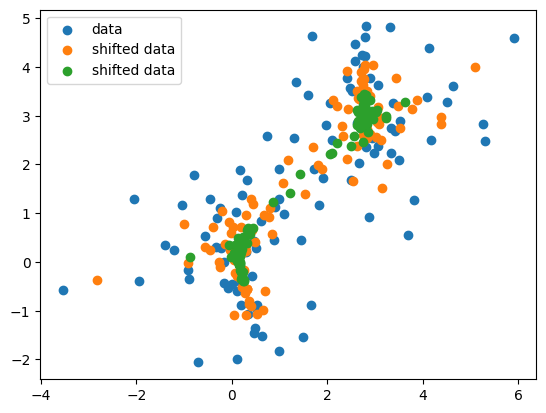

In [6]:
shift1 = data2 + MS_step(data2, data2, sigma2, g_function=g)
shift2 = shift1 + MS_step(data2, shift1, sigma2, g_function=g)
shift2 = shift2 + MS_step(data2, shift2, sigma2, g_function=g)

plt.scatter(data2[:,0],data2[:,1], label="data")
plt.scatter(shift1[:, 0],shift1[:, 1], label="shifted data")
plt.scatter(shift2[:, 0],shift2[:, 1], label="shifted data")
plt.legend()
plt.show()

**4.a)** Implement the function `MS_point` which iterates `MS_step` until convergence (*e.g.*, until the estimate changes by less than $\epsilon=0.01$).<br/>

It should return $x^*$, the **mode** associated to the point $x$ after convergence.
You should not modify the original data which would break the algorithm.

**4.b)** Test it on your synthetic data and visualize the results.

In [7]:
def MS_point(data, sigma, eps=0.01, g_function=g, eps_fuse=0.05, return_labels=False):
    t1 = time.perf_counter_ns()
    x = data
    i = 0
    while True:
        i += 1
        x_star = x + MS_step(data, x, sigma, g_function=g_function)
        dist = sqr_mahalanobis_distance(x_star, x, sigma).max()
        if dist < eps ** 2:
            break
        x = x_star
    t2 = time.perf_counter_ns()
    print("Time elapsed for mean shift : ", (t2-t1) / 1e6, "ms")
    
    #fuse the points that are too close
    t1 = time.perf_counter_ns()
    centroids = x
    c = True
    while c:
        c = False
        for i, centroid in enumerate(centroids):
            dists = sqr_mahalanobis_distance(centroids, centroid, sigma)
            dists = np.where(dists < eps_fuse**2, 0, dists)
            dists[i] = np.inf
            if np.any(dists == 0):
                centroids = centroids[dists != 0]
                c = True
                break
    t2 = time.perf_counter_ns()
    print("Time elapsed for fusion : ", (t2-t1) / 1e6, "ms")
    
    # assign each point to the closest centroid
    t1 = time.perf_counter_ns()
    dists = sqr_mahalanobis_distance(data[:,None,:], centroids, sigma)
    labels = np.argmin(dists, axis=1)

    x_stars = np.zeros(x.shape)
    for i, centroid in enumerate(centroids):
        x_stars[labels == i] = centroid
    t2 = time.perf_counter_ns()
    print("Time elapsed for labels : ", (t2-t1) / 1e6, "ms")
    
    if return_labels:
        return x_stars, labels
    return x_stars

**5.a)** Implement the `MS` function, which implements the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes so that there are not two modes at distance -- normalized by `sigma` -- smaller than 0.5, and such that all points are assigned to the closest mode, at a distance smaller than 0.5. <br/>
The function must return a list of the modes and a label (corresponding to a mode) for each point. <br/>

In [8]:
def MS(data, sigma, eps=0.01, g_function=g, eps_fuse=0.5):
    x_star, labels = MS_point(data, sigma, eps=eps, g_function=g_function, eps_fuse=eps_fuse, return_labels=True)
    return x_star, labels

In [9]:
"""
this are functions that apply steps on point rather than on the whole dataset.
It should be faster because some points will converge faster than other, but in practice python is just too slow.
"""
def MS_point_step(data, x, sigma, g_function=g):
    norm = np.linalg.norm(data-x, axis=1)
    gs = g_function((norm/sigma)**2)
    M = np.sum(data * gs[:,None], axis=0) / np.sum(gs, axis=0) - x
    
    return M

def MS_point_point(data, x, sigma, eps=0.01, g_function=g):
    while True:
        x_star = x + MS_point_step(data, x, sigma, g_function=g_function)
        if np.linalg.norm(x_star-x) < eps:
            break
        x = x_star
    
    return x_star

def MS_loops(data, sigma, eps=0.01, g_function=g, eps_fuse=0.5):
    t1 = time.perf_counter_ns()
    x_stars = np.zeros(data.shape)
    for i, x in enumerate(data):
        x_stars[i] = MS_point_point(data, x, sigma, eps=eps, g_function=g_function)
    t2 = time.perf_counter_ns()
    print("Time elapsed for mean shift : ", (t2-t1) / 1e6, "ms")

    #fuse the points that are too close
    t1 = time.perf_counter_ns()
    eps_fuse /= sigma
    centroids = x_stars
    c = True
    while c:
        c = False
        for i, centroid in enumerate(centroids):
            dists = np.linalg.norm(centroids-centroid, axis=1)
            dists = np.where(dists < eps_fuse, 0, dists)
            dists[i] = np.inf
            if np.any(dists == 0):
                centroids = centroids[dists != 0]
                c = True
                break
    t2 = time.perf_counter_ns()
    print("Time elapsed for fusion : ", (t2-t1) / 1e6, "ms")
            
    t1 = time.perf_counter_ns()
    # assign each point to the closest centroid
    labels = np.argmin(np.linalg.norm(data[:,None,:]-centroids, axis=2), axis=1)

    for i, centroid in enumerate(centroids):
        x_stars[labels == i] = centroid
    t2 = time.perf_counter_ns()
    print("Time elapsed for labels : ", (t2-t1) / 1e6, "ms")
    
    return x_stars, labels

**5.b)** Test it on your synthetic data and visualize the results for different values of `sigma`. <br/>

In [10]:
def visualize(data, sigma):
    x_star, label = MS(data, sigma, eps=0.05)

    plt.scatter(data[:,0],data[:,1], label="predicted label", marker="+", c=label, cmap="tab10")
    plt.scatter(x_star[:, 0],x_star[:, 1], label="modes")

    plt.axis('equal')
    plt.legend()
    plt.show()

In [11]:
x_star, label = MS(data1, sigma1)
x_star, label = MS_loops(data1, sigma1)

Time elapsed for mean shift :  33.6339 ms
Time elapsed for fusion :  0.5103 ms
Time elapsed for labels :  0.5641 ms
Time elapsed for mean shift :  202.8107 ms
Time elapsed for fusion :  0.1414 ms
Time elapsed for labels :  0.0671 ms


Time elapsed for mean shift :  79.7403 ms
Time elapsed for fusion :  1.2712 ms
Time elapsed for labels :  0.6975 ms


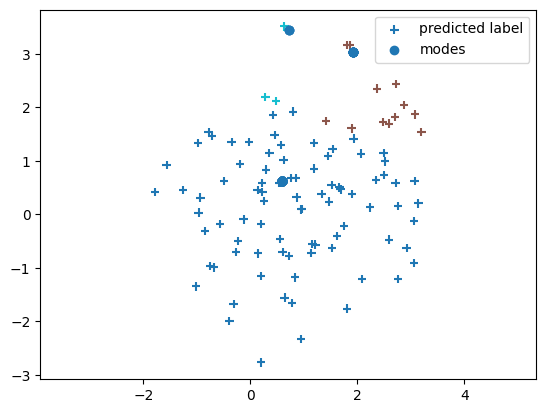

Time elapsed for mean shift :  23.795 ms
Time elapsed for fusion :  0.464 ms
Time elapsed for labels :  0.6359 ms


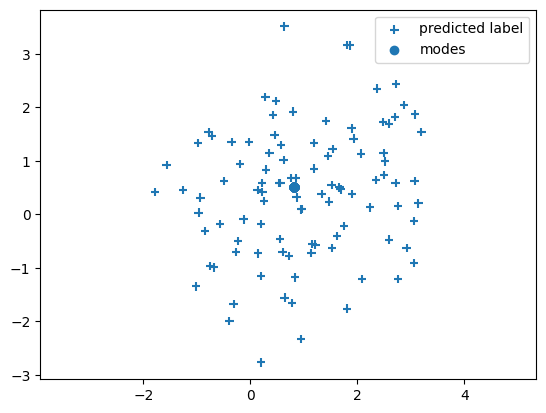

Time elapsed for mean shift :  45.6485 ms
Time elapsed for fusion :  2.1519 ms
Time elapsed for labels :  1.124 ms


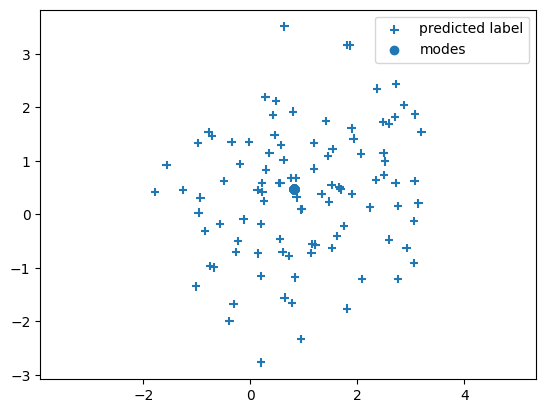

In [12]:
for sigma in [0.205, 0.5, 0.6]:
    visualize(data1, sigma)

Time elapsed for mean shift :  30.1478 ms
Time elapsed for fusion :  2.2101 ms
Time elapsed for labels :  0.6116 ms


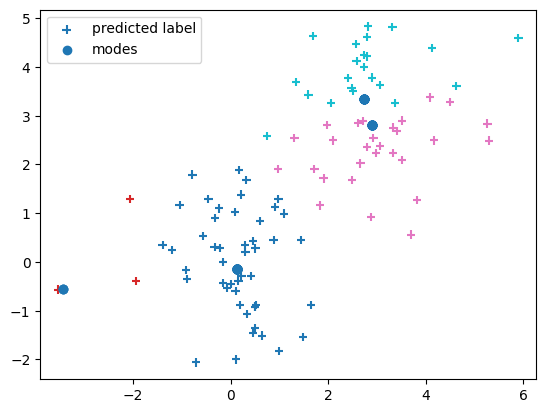

Time elapsed for mean shift :  23.0221 ms
Time elapsed for fusion :  1.2481 ms
Time elapsed for labels :  0.2226 ms


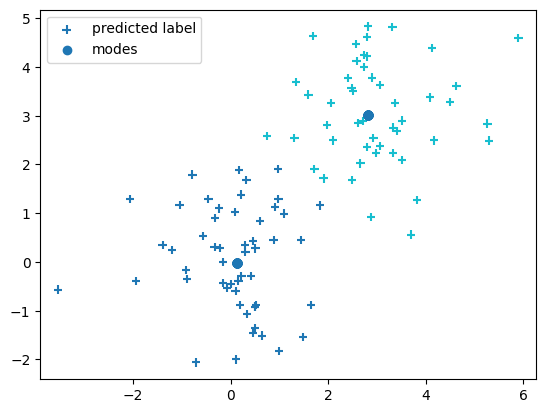

Time elapsed for mean shift :  21.7411 ms
Time elapsed for fusion :  1.7864 ms
Time elapsed for labels :  0.3108 ms


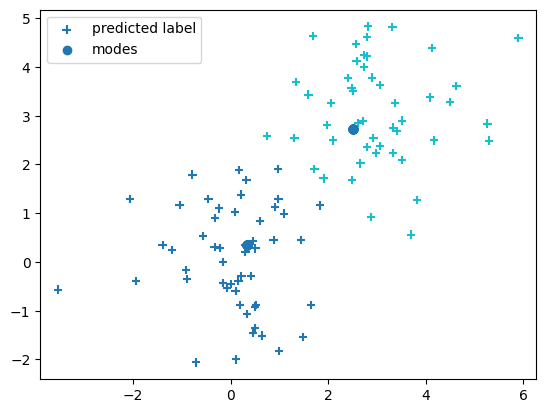

Time elapsed for mean shift :  13.9969 ms
Time elapsed for fusion :  0.4761 ms
Time elapsed for labels :  0.2324 ms


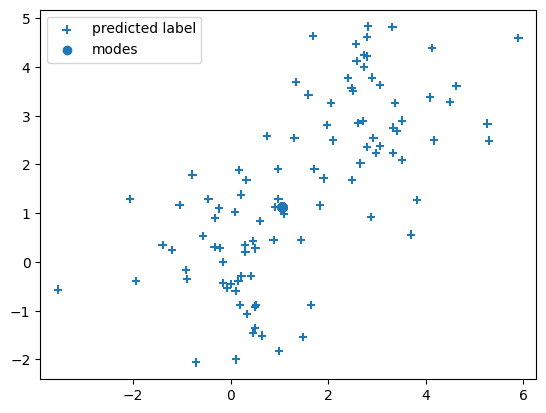

In [13]:
for sigma in [0.4, 0.6, 2, 4]:
    visualize(data2, sigma)

**5.c)** Comment on the result for each `data` vector and the different `sigma`.

_____

On remarque que le nombre de modes finaux est assez sensible au sigma. Cependant, si il y a k modes pour sigma dans [a, b], leur position varie assez peu en fonction de sigma.

Pour `data1`, on remarque que comme prévu, les données sont assez peu séparables, et il faut un sigma assez faible pour ne pas se retrouver avec un seul mode. Cependant, pour cette même raison, le nombre de modes est extrêmement sensible au sigma, les points éloignés étant leur propre mode.

Pour `sigma = 0.6`, il y a deux modes, l'un est bien en `(0, 0)`, mais l'autre n'est pas là où il faut.

Pour `data2`, les données sont plus facilement séparables, comme prévu. Avec des sigma trop faibles, on a le même problème pour les points trop isolés qui forment leur propre mode, mais dès que ce problème disparait on a deux modes clairement séparés pile au bon endroit.

## 2. Segmentation

**6.a)** Load the image `veggies_small.jpg` it and convert it to the `Lab` colorspace. <br/>


In [14]:
path = "veggies_small.jpg"
img = plt.imread(path)
img = np.array(img, dtype=np.float64) / 255
img = rgb2lab(img)

print(np.max(img, axis=(0,1)), np.min(img, axis=(0,1)))

print(img.shape)

[97.25974427 38.3585606  48.57870408] [  2.16185644 -34.01924478 -19.66672475]
(62, 50, 3)


**6.b)** Why is it necessary to change the colorspace? What are the ranges of the colorvalues for this image in the Lab space ?

_____

It is necessary to change the colorspace because the gaussian kernel is isotropic and the color space is not. In the RGB space, the distance between two colors is not the same for all colors. In the Lab space, the distance between two colors is the same for all colors. For example, the distance between red and green is the same as the distance between blue and yellow in the Lab space, but not in the RGB space.
This means that distance between colors in the lab space is closer to tha actual distance between the perceived colors.

Moreover, this space allows for a clear separation of luminosity and color, which might have different uses for the segmentation.

The ranges of the colorvalues for this image in the Lab space are [0, 100] for L, [-127, 128] for a and [-127, 128] for b.
_____

In Mean Shift segmentation, all pixels in the image will be treated as data points including both their color and position in the image.

**7.a)** Convert the *(N, M, 3)* image into an *(NM, 5)* array incuding color and position information for each point. *(Tip: use the `np.meshgrid` function)* <br/>
**b)** What would be a meaningful value for `sigma`?

In [15]:
x, y = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')

data = np.stack([x, y, img[:,:,0], img[:,:,1], img[:,:,2]], axis=2)
data = data.reshape((-1, 5))

sigma = 0.5

**8.a)** Use the `MS` function from the previous section to compute a meaningful segmentation of the image. <br/>
*(Tip: if your `MS` function is too slow, it might be because of your function`MS_step`, or because of mode merging. Try to rewrite your answers replacing some python loops with `np.sum` and other built-in `numpy` functions that are much faster.)* <br/>

In [16]:
#x_star, label = MS(data, sigma, eps=0.01, g_function=g, eps_fuse=0.5)

In [17]:
#label = label.reshape(img.shape[:2])
#plt.imshow(label)
#plt.show()

_____

Comme prévu, on est clairement dans un cas anisotropique.

Time elapsed for mean shift :  213214.1289 ms
Time elapsed for fusion :  31.2894 ms
Time elapsed for labels :  5.2209 ms


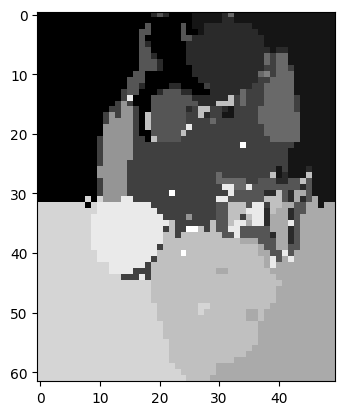

Time elapsed for mean shift :  128686.364 ms
Time elapsed for fusion :  24.1587 ms
Time elapsed for labels :  6.6566 ms


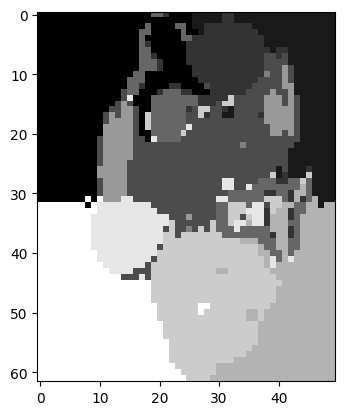

Time elapsed for mean shift :  74859.7005 ms
Time elapsed for fusion :  20.7474 ms
Time elapsed for labels :  4.4252 ms


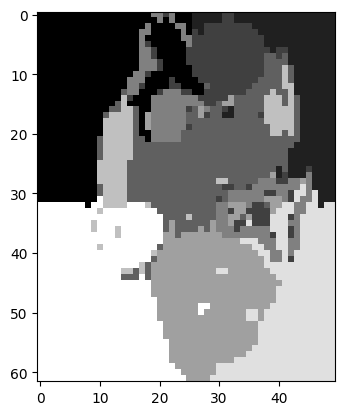

In [34]:
# normalised_data = data.copy()
# mean = np.mean(normalised_data, axis=0)
# std = np.std(normalised_data, axis=0)
# normalised_data -= mean
# normalised_data /= std

data_cov = np.cov(data.T)

for sigma in [0.2, 0.3, 0.4]:
    x_star, label = MS(data, data_cov * sigma, eps=0.05, g_function=g, eps_fuse=0.5)
    label = label.reshape(img.shape[:2])
    
    plt.imshow(label)
    plt.show()

_____

Dans le cas présent rajouter des coordonnées semble ne pase servir à grand chose à part à casser l'arrière plan. Si on met un sigma différent pour la position au point que l'arrière plan ne soit pas segmenté, alors on ne détectera plus non plus la différence entre deux objets semblables séparés spatialement, ce qui revient à ne pas mettre la position...

Time elapsed for mean shift :  108015.5182 ms
Time elapsed for fusion :  7.273 ms
Time elapsed for labels :  2.2528 ms


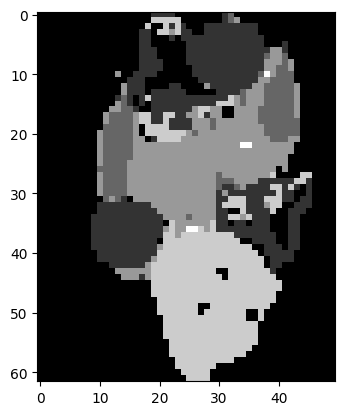

Time elapsed for mean shift :  52399.3839 ms
Time elapsed for fusion :  3.5998 ms
Time elapsed for labels :  1.6388 ms


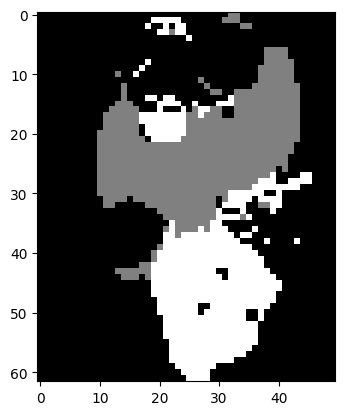

Time elapsed for mean shift :  36414.0516 ms
Time elapsed for fusion :  3.6135 ms
Time elapsed for labels :  1.6437 ms


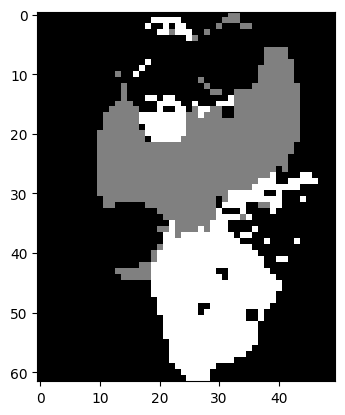

In [29]:
trunc = data[:, 2:]
trunc_cov = np.cov(trunc.T)

for sigma in [0.2, 0.3, 0.4]:
    x_star, label = MS(trunc, trunc_cov*sigma, eps=0.05, g_function=g, eps_fuse=0.5)
    label = label.reshape(img.shape[:2])
    plt.imshow(label)
    plt.show()

Time elapsed for mean shift :  30374.3993 ms
Time elapsed for fusion :  1.9976 ms
Time elapsed for labels :  1.3391 ms


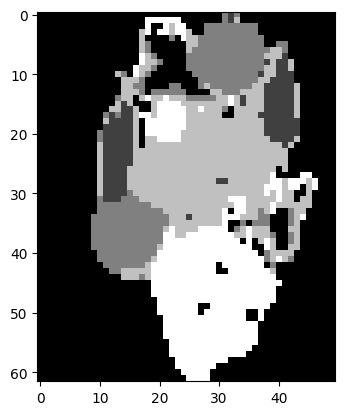

Time elapsed for mean shift :  50567.6296 ms
Time elapsed for fusion :  1.4581 ms
Time elapsed for labels :  0.8751 ms


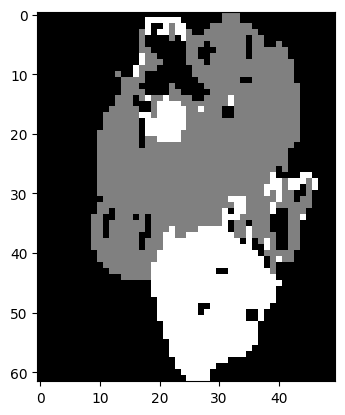

Time elapsed for mean shift :  28090.2173 ms
Time elapsed for fusion :  1.3779 ms
Time elapsed for labels :  0.8612 ms


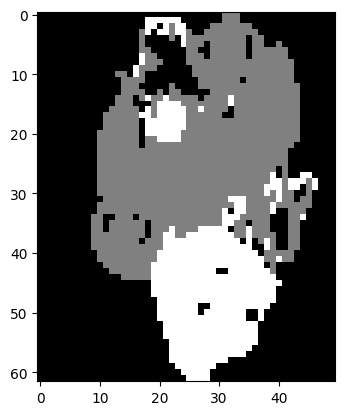

In [ ]:
for sigma in [0.55, 0.6, 0.65]:
    x_star, label = MS(normalised_data, sigma, eps=0.01, g_function=g, eps_fuse=0.5)
    label = label.reshape(img.shape[:2])
    plt.imshow(label)
    plt.show()

**8.b)** Visualize the result as an image by replacing the color values of each pixel with its associated mode (ie. with its label) <br/>

**8.c)** Experiment with different `sigma` values and comment on the results.

In [ ]:
# Help for plotting as an image
def plot_MS_legumes(img, sigma):
    labels, modes = #...
    labels = labels.reshape((img.shape[0], img.shape[1]))
    mode_img = np.zeros_like(img)
    for coord, label in np.ndenumerate(labels):
        mode_img[coord] = modes[label][:3] # Take the first 3 channels for Lab values !
    plt.imshow(lab2rgb(mode_img))

SyntaxError: invalid syntax (1533274460.py, line 3)